# Sample 15arc-sec GEBCO_2020.nc + Bedmachine on OM4p125 grid

## Apply edits to the topography.
## Apply ice9 algorithm to fill lakes and inland seas. 

In [1]:
#Notebook editor: Mitch Bushuk

# Stephen.Griffies@noaa.gov 
# Alistair.Adcroft@noaa.gov
# Robert.Hallberg@noaa.gov
# Niki.Zadeh@noaa.gov
# Raphael.Dussin@noaa.gov

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import netCDF4
import xarray as xr
import cmocean
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [3]:
# def ice9it(i,j,depth):
#   # Iterative implementation of "ice 9"
#   wetMask = 0*depth
#   (nj,ni) = wetMask.shape
#   stack = set()
#   stack.add( (j,i) )
#   while stack:
#     (j,i) = stack.pop()
#     if wetMask[j,i] or depth[j,i] >= 0: continue
#     wetMask[j,i] = 1
#     if i>0: stack.add( (j,i-1) )
#     else: stack.add( (j,ni-1) )
#     if i<ni-1: stack.add( (j,i+1) )
#     else: stack.add( (0,j) )
#     if j>0: stack.add( (j-1,i) )
#     if j<nj-1: stack.add( (j+1,i) )
#     else: stack.add( (j,ni-1-i) )
#   return wetMask

In [4]:
def get_indices_2dcurvilinear(lon_grid, lat_grid, x, y):
    """This function returns the j,i indices for the grid point closest to the input lon(i,j),lat(i,j) coordinates."""
    """It returns the j,i indices."""
    
    cost=np.fabs((lon_grid-x)**2 + (lat_grid-y)**2)
    costm=np.where(cost==cost.min())
    j0,i0 = costm[0][0], costm[1][0]
    return j0,i0

def get_indices_1dlatlon(lon_grid, lat_grid, x, y):
    """This function returns the j,i indices for the grid point closest to the input lon(i),lat(j) coordinates."""
    """It returns the j,i indices."""

    lons = np.fabs(np.squeeze(lon_grid)-x)
    lonm = np.where(lons==lons.min())
    lats = np.fabs(np.squeeze(lat_grid)-y)
    latm = np.where(lats==lats.min())  
    j0, i0 = latm[0][0], lonm[0][0]
    return j0,i0

def get_indices(lon_grid, lat_grid, x, y):
    """Returns j,i indices of lat_grid and lon grid nearest to x,y"""
    if len(lon_grid.shape)==1:
        J,I = get_indices_1dlatlon(lon_grid, lat_grid, x, y)
    else:
        J,I = get_indices_2dcurvilinear(lon_grid, lat_grid, x, y)
    return J,I

def zmask(fld, threshold=0.):
    """Convenience function that returns fld with values <= threshold masked to NaN"""
    return np.ma.array(fld.filled(threshold), mask=(fld.filled(threshold)<=threshold) )

class Region:
    """Convenient way to pass regions around"""
    def __init__(self, center_lon, center_lat, width_lon=2., width_lat=2.):
        self.center_lon = center_lon
        self.center_lat = center_lat
        self.width_lon = width_lon
        self.width_lat = width_lat
    def west(self, scale=2):
        return self.center_lon - self.width_lon / scale
    def east(self, scale=2):
        return self.center_lon + self.width_lon / scale
    def south(self, scale=2):
        return self.center_lat - self.width_lat / scale
    def north(self, scale=2):
        return self.center_lat + self.width_lat / scale
    def lon_bnds(self, scale=2):
        return self.west(scale=scale), self.east(scale=scale)
    def lat_bnds(self, scale=2):
        return self.south(scale=scale), self.north(scale=scale)
    def window(self, DS, widen=0):
        Js,Is = get_indices(DS.lonh, DS.lath, self.west(), self.south())
        Je,Ie = get_indices(DS.lonh, DS.lath, self.east(), self.north())
        nj,ni = DS.lath.shape[0], DS.lonh.shape[-1]
        Js, Is, Je, Ie = min(Js,Je), min(Is,Ie), max(Js,Je), max(Is,Ie) # Make sure indices are ordered
        Js,Is = max(0, Js - widen),max(0 , Is - widen)
        Je,Ie = min(Je + widen, nj), min(Ie + widen, ni)
        return Js, Is, Je, Ie

class OM4_data:
    """Structure for OM4 data with grid, depth, and mask"""
    def __init__(self, hgrid_file, depth_file, mask_file):
        x = netCDF4.Dataset(hgrid_file).variables['x'][:]
        y = netCDF4.Dataset(hgrid_file).variables['y'][:]
        self.lonq = x[::2,::2]
        self.latq = y[::2,::2]
        self.lonh = x[1::2,1::2]
        self.lath = y[1::2,1::2]
        self.depth = netCDF4.Dataset(depth_file).variables['deptho'][:]
        self.mask = netCDF4.Dataset(mask_file).variables['mask'][:]
        # Check masks match
        if ((1-self.depth.mask - self.mask)**2).max()>0: print('OM4 masks do not match!')

class GEBCO_data:
    """Structure for GEBCO data with corner coordinates for proper plotting, and elevation converted to depth"""
    def __init__(self, gebco_file, lon='lon', lat='lat', height='elevation', scale=1.):
        nc = netCDF4.Dataset(gebco_file) 
        x = nc.variables[lon][:]
        y = nc.variables[lat][:]
        dy, dx = y[1] - y[0], x[1] - x[0]
        self.nj, self.ni = len(y), len(x)
        self.res = self.ni//360
        print('Resolution =', self.res, 'cells/degree')
        x = np.roll(x, 120*self.res); x[x>60] -= 360
        yq, xq = np.zeros(self.nj+1), np.zeros(self.ni+1)
        yq[:-1], xq[:-1] = y - dy/2, x - dx/2
        yq[-1], xq[-1] = y[-1] + dy/2, x[-1] + dx/2
        self.lonq = xq
        self.latq = yq
        self.lonh = x
        self.lath = y
        self.depth = - np.roll(nc[height][:]*scale, 120*self.res, axis=1)
        print('GEBCO loaded with (nj,ni) = ', self.depth.shape, ' min(lon) = ',
              self.lonq.min(), ' max(lon) = ', self.lonq.max())

class OM5_data:
    """Structure for OM4 data with grid and initialzed from a depth"""
    def __init__(self, hgrid_file, depth_file):
        x = netCDF4.Dataset(hgrid_file).variables['x'][:]
        y = netCDF4.Dataset(hgrid_file).variables['y'][:]
        self.lonq = x[::2,::2]
        self.latq = y[::2,::2]
        self.lonh = x[1::2,1::2]
        self.lath = y[1::2,1::2]
        self.depth = netCDF4.Dataset(depth_file).variables['depth'][:]
        self.depth_unmodded = 1.*self.depth # Unedited
        if ((netCDF4.Dataset(depth_file).variables['x'][:]-self.lonh)**2).max()>0:
            print('OM5 longitudes are inconsistent!')
        if ((netCDF4.Dataset(depth_file).variables['y'][:]-self.lath)**2).max()>0:
            print('OM5 latitudes are inconsistent!')
    def reset(self, region=None):
        if region is None:
            self.depth[:,:] = self.depth_unmodded[:,:]
        else:
            Js,Is = get_indices(self.lonq, self.latq, region.west(), region.south())
            Je,Ie = get_indices(self.lonq, self.latq, region.east(), region.north())
            self.depth[Js:Je,Is:Ie] = self.depth_unmodded[Js:Je,Is:Ie]

In [5]:
def deepest_sill(DS, region, end_points):
    """Find deepest path between (lonA,latA,lonB,latB)"""
    lonW, lonE = min(end_points[0], end_points[2]), max(end_points[0], end_points[2])
    latS, latN = min(end_points[1], end_points[3]), max(end_points[1], end_points[3])
    Js,Is,Je,Ie = region.window(DS)
    Ja,Ia = get_indices(DS.lonh, DS.lath, end_points[0], end_points[1])
    Jb,Ib = get_indices(DS.lonh, DS.lath, end_points[2], end_points[3])
    Ja,Jb = Ja-Js,Jb-Js
    Ia,Ib = Ia-Is,Ib-Is
    D = DS.depth[Js:Je+1,Is:Ie+1]
    M = 0*D
    nj,ni = M.shape
    Mj = np.zeros((nj,ni),dtype=int)
    Mi = np.zeros((nj,ni),dtype=int)
    stack = set()
    stack.add( (Ja,Ia,D[Ja,Ia],Ja,Ia) )
    while stack:
        (j,i,deepest_sill_on_path,sill_j,sill_i) = stack.pop()
        if M[j,i]>=deepest_sill_on_path: continue
        if D[j,i]<deepest_sill_on_path:
            deepest_sill_on_path,sill_j,sill_i = D[j,i],j,i
        M[j,i] = deepest_sill_on_path
        Mj[j,i] = sill_j
        Mi[j,i] = sill_i
        if i>0: stack.add( (j,i-1,deepest_sill_on_path,sill_j,sill_i) )
        if i<ni-1: stack.add( (j,i+1,deepest_sill_on_path,sill_j,sill_i) )
        if j>0: stack.add( (j-1,i,deepest_sill_on_path,sill_j,sill_i) )
        if j<nj-1: stack.add( (j+1,i,deepest_sill_on_path,sill_j,sill_i) )
    return M[Jb,Ib], Mj[Jb,Ib] + Js, Mi[Jb,Ib] + Is

In [6]:
def map_region(region, vmin, vmax, GEBCO, OM4, OM5, title,
               gebco_contours=[0,500], cmap=cmocean.cm.deep, text_depths=True,
               sill_check=None):
    """This function maps a region comparing GEBCO, OM4 and OM5"""

    def locext():
        if vmin==0: return 'max'
        return 'both'
    def add_gebco_contours(thisax, levels=gebco_contours):
        thisax.contour(GEBCO.lonh[Gis:Gie], GEBCO.lath[Gjs:Gje], zmask( GEBCO.depth[Gjs:Gje,Gis:Gie] ),
                       levels=levels, linestyles='solid', colors='green')
    def shade(thisax, DS, Is, Ie, Js, Je, title, data=None, cmap=cmap, vmin=vmin, vmax=vmax):
        if data is None:
            q = DS.depth[Js:Je,Is:Ie]
        else:
            q = data[Js:Je,Is:Ie]
        if len(DS.lonq.shape)>1:
            im = thisax.pcolormesh(DS.lonq[Js:Je+1,Is:Ie+1], DS.latq[Js:Je+1,Is:Ie+1], zmask( q ),
                                   cmap=cmap, vmin=vmin, vmax=vmax)
        else:
            im = thisax.pcolormesh(DS.lonq[Is:Ie+1], DS.latq[Js:Je+1], zmask( q ), cmap=cmap, vmin=vmin, vmax=vmax)
        thisax.set_facecolor('lightgray')
        cbar = plt.colorbar(im, ax=thisax, pad=0.01, spacing='uniform', extend=locext(),
                            shrink=0.95, orientation='vertical')
        add_gebco_contours(thisax)
        thisax.set_xlabel("Longitude"); thisax.set_ylabel("Latitude")
        thisax.set_xlim(xlim); thisax.set_ylim(ylim); thisax.set_title(title);
    def channels(thisax):
        def channel_box(thisax, coords, ls='y:'):
            x0,x1,y0,y1 = coords
            thisax.plot([x0,x1,x1,x0,x0],[y0,y0,y1,y1,y0],ls)
        channel_box(thisax, (-5.9,  -5.4, 35.8, 36.2), ls='r:') # U Gibraltar
        channel_box(thisax, (26.4,  26.8, 40.4, 40.6), ls='r:') # U Dardanelles
        channel_box(thisax, (28.8,  29.4, 41.1, 41.2)) # V Bosporus
        channel_box(thisax, (43.25, 43.5, 12.6, 12.8)) # V Red Sea Bab-el-Mendeb
        channel_box(thisax, (141.5, 141.7, 52.0,  52.15)) # V Sakhalin/Russia


    # GEBCO indices
    Gjs,Gis,Gje,Gie = region.window(GEBCO)
    print('Gebco (js:je,is:ie) = %d:%d,%d:%d'%(Gjs,Gje,Gis,Gie))

    # MOM6 indices for OM4 grid
    M4js,M4is,M4je,M4ie = region.window(OM4, widen=1)
    print('OM4 model (js:je,is:ie) = %d:%d,%d:%d'%(M4js,M4je,M4is,M4ie))

    # MOM6 indices for OM5 grid
    M5js,M5is,M5je,M5ie = region.window(OM5, widen=1)
    print('OM5 model (js:je,is:ie) = %d:%d,%d:%d'%(M5js,M5je,M5is,M5ie))

    xlim,ylim = (region.lon_bnds()), (region.lat_bnds())
    print('Using xlim =',xlim, 'ylim =', ylim)
    # Add margins for annotations
    axlim,aylim = (region.lon_bnds(scale=2.1)), (region.lat_bnds(scale=2.1))

    fig, ax = plt.subplots(2, 2, figsize=(14,10)) 

    # GEBCO
    thisax = ax[0,0]
    shade(thisax, GEBCO, Gis, Gie, Gjs, Gje, 'GEBCO')
    if M5je-M5js<30 and M5ie-M5is<30:
        # Overlay OM5 mesh
        for j in range(M5js, M5je+1):
            thisax.plot(OM5.lonq[j,M5is:M5ie+1],OM5.latq[j,M5is:M5ie+1],'k:')
        for i in range(M5is, M5ie+1):
            thisax.plot(OM5.lonq[M5js:M5je+1,i],OM5.latq[M5js:M5je+1,i],'k:')
    if sill_check is not None:
        for sc in sill_check:
            sill,j,i = deepest_sill(GEBCO, region, sc)
            print('Sill =', sill)
            thisax.plot([sc[0],sc[2]], [sc[1],sc[3]], 'rx')
            thisax.plot(GEBCO.lonh[i], GEBCO.lath[j], 'ro')

    # Interpolated topography
    thisax = ax[0,1]
    shade(thisax, OM5, M5is, M5ie, M5js, M5je, 'Merged (no edits); GEBCO(cont), OM4 mask(x)', data=OM5.depth_unmodded)

    # Overlay OM4 mask or annotate with indices
    for j in range(M4js, M4je):
        for i in range(M4is, M4ie):
            if OM4.mask[j,i]<=0:
                thisax.plot(OM4.lonh[j,i], OM4.lath[j,i], 'rx' )
    # Write OM5 indices (might have collisions with OM4 mask)
    for j in range(M5js, M5je):
        for i in range(M5is, M5ie):
            if (OM5.depth[j,i]>0 and aylim[0]<OM5.lath[j,i] and OM5.lath[j,i]<aylim[1] and
                  axlim[0]<OM5.lonh[j,i] and OM5.lonh[j,i]<axlim[1] and text_depths):
                thisax.text(OM5.lonh[j,i], OM5.lath[j,i], '%d,\n%d'%(j,i), color='m',
                           horizontalalignment='center', verticalalignment='center')
        
    # OM4 topography
    thisax = ax[1,0]
    shade(thisax, OM4, M4is, M4ie, M4js, M4je, 'OM4 (final at runtime); GEBCO(cont)')
    # Annotate with depths
    for j in range(M4js, M4je):
        for i in range(M4is, M4ie):
            if (OM4.mask[j,i]>0 and
                aylim[0]<OM4.lath[j,i] and OM4.lath[j,i]<aylim[1] and
                axlim[0]<OM4.lonh[j,i] and OM4.lonh[j,i]<axlim[1] and text_depths):
                    thisax.text(OM4.lonh[j,i], OM4.lath[j,i], '%.1f'%(OM4.depth[j,i]), color='m',
                           horizontalalignment='center', verticalalignment='center')
    channels(thisax)

    # Candidate topography
    thisax = ax[1,1]
    shade(thisax, OM5, M5is, M5ie, M5js, M5je, 'Edited OM5 topography; GEBCO(cont), edits(.)')
    # Indicate edits
    for j in range(M5js, M5je):
        for i in range(M5is, M5ie):
            if OM5.depth[j,i]!=OM5.depth_unmodded[j,i]:
                thisax.text(OM5.lonh[j,i], OM5.lath[j,i], '%.1f'%(OM5.depth[j,i]), color='r',
                           horizontalalignment='center', verticalalignment='center')
                thisax.plot([OM5.lonq[j,i],OM5.lonq[j,i+1],OM5.lonq[j+1,i+1],OM5.lonq[j+1,i],OM5.lonq[j,i]],
                            [OM5.latq[j,i],OM5.latq[j,i+1],OM5.latq[j+1,i+1],OM5.latq[j+1,i],OM5.latq[j,i]], 'r--')
            elif (text_depths and OM5.depth[j,i]>0 and
                aylim[0]<OM5.lath[j,i] and OM5.lath[j,i]<aylim[1] and
                axlim[0]<OM5.lonh[j,i] and OM5.lonh[j,i]<axlim[1]):
                thisax.text(OM5.lonh[j,i], OM5.lath[j,i], '%.1f'%(OM5.depth[j,i]), color='r',
                           horizontalalignment='center', verticalalignment='center')

    plt.suptitle(title)
    plt.tight_layout()

In [7]:
def broadview(xlim, ylim, vmin, vmax, title, om4=True, new=True):
    def locplot(x, y, z, title):
        plt.figure(figsize=(20,8)) 
        plt.pcolormesh(x, y, z, cmap=cmocean.cm.deep, vmin=vmin, vmax=vmax)  
        plt.gca().set_facecolor('lightgray')
        plt.xlabel('Longitude'); plt.ylabel('Latitude')
        cbar = plt.colorbar(pad=0.01, spacing='uniform', extend='max', shrink=0.95, orientation='vertical')
        plt.title(title, fontsize=20)
        plt.xlim(xlim); plt.ylim(ylim);

    locplot(OM5.lonq, OM5.latq, zmask( OM5.depth_unmodded ), 'OM5 1/4th %s before editing'%(title))
    if new:
        locplot(OM5.lonq, OM5.latq, zmask( OM5.depth ), 'OM5 1/4th %s after editing'%(title))
    if om4:
        locplot(OM4.lonq, OM4.latq, zmask( OM4.depth ), 'OM4 1/4th %s'%(title))

Resolution = 240 cells/degree
GEBCO loaded with (nj,ni) =  (43200, 86400)  min(lon) =  -300.0  max(lon) =  60.0


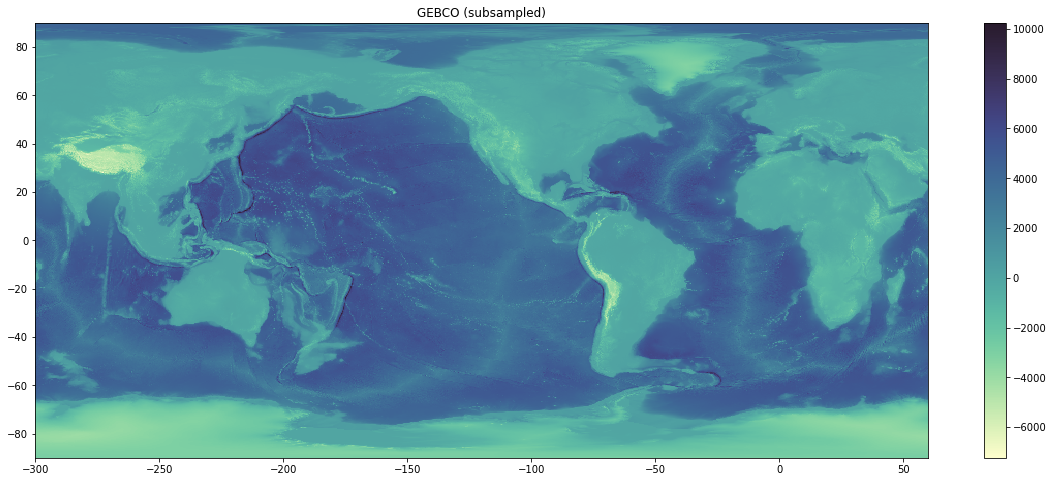

In [8]:
# GEBCO-2020 + Bedmachine combined topography 

fname_gebco  = "/archive/gold/datasets/topography/GEBCO_2023/GEBCO_2023.nc"

GEBCO = GEBCO_data(fname_gebco)

plt.figure(figsize=(20,8))
plt.pcolormesh(GEBCO.lonq[::100], GEBCO.latq[::100], GEBCO.depth[::100,::100], cmap=cmocean.cm.deep)
plt.colorbar(); plt.title('GEBCO (subsampled)');

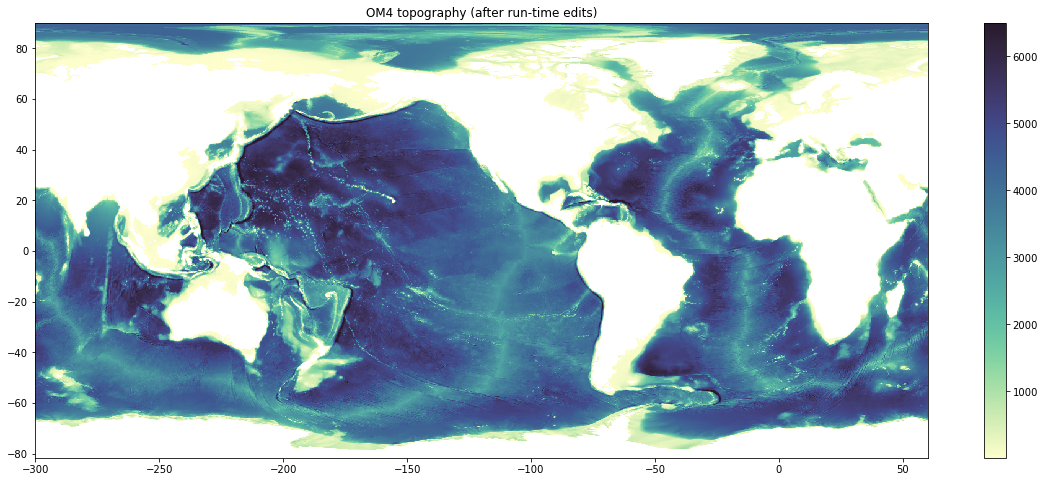

In [9]:
OM4 = OM4_data('/archive/gold/datasets/OM4_025/mosaic.v20170622.unpacked/ocean_hgrid.nc',
               '/archive/gold/datasets/OM4_025/mosaic.v20170622.unpacked/ocean_static.nc',
               '/archive/gold/datasets/OM4_025/mosaic.v20170622.unpacked/ocean_mask.nc')
plt.figure(figsize=(20,8))
plt.pcolormesh(OM4.lonq, OM4.latq, OM4.depth, cmap=cmocean.cm.deep)
plt.colorbar(); plt.title('OM4 topography (after run-time edits)');

OM5 longitudes are inconsistent!
OM5 latitudes are inconsistent!


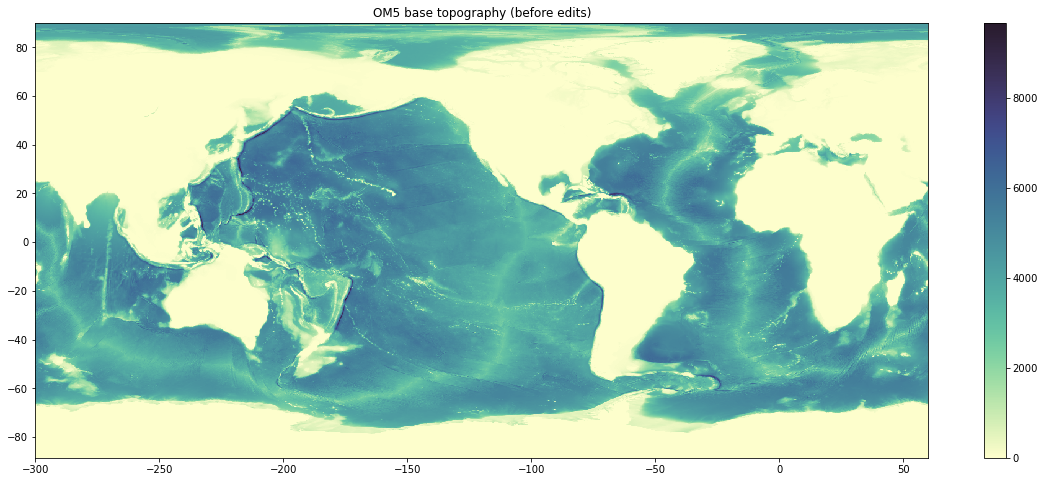

In [10]:
OM5 = OM5_data('/archive/jpk/OM5/OM5_025/prototypes/v20231109/tile_files/ocean_hgrid.nc',
               '/archive/jpk/OM5/OM5_025/prototypes/v20231109/tile_files/ocean_topog_merged.nc')

plt.figure(figsize=(20,8))
plt.pcolormesh(OM5.lonq, OM5.latq, OM5.depth, cmap=cmocean.cm.deep)
plt.colorbar(); plt.title('OM5 base topography (before edits)');

In [11]:
# ---------------------------------------------------------------------- 
# -------------------Barents and Norwegion Sea----------------------- 
# ---------------------------------------------------------------------- 

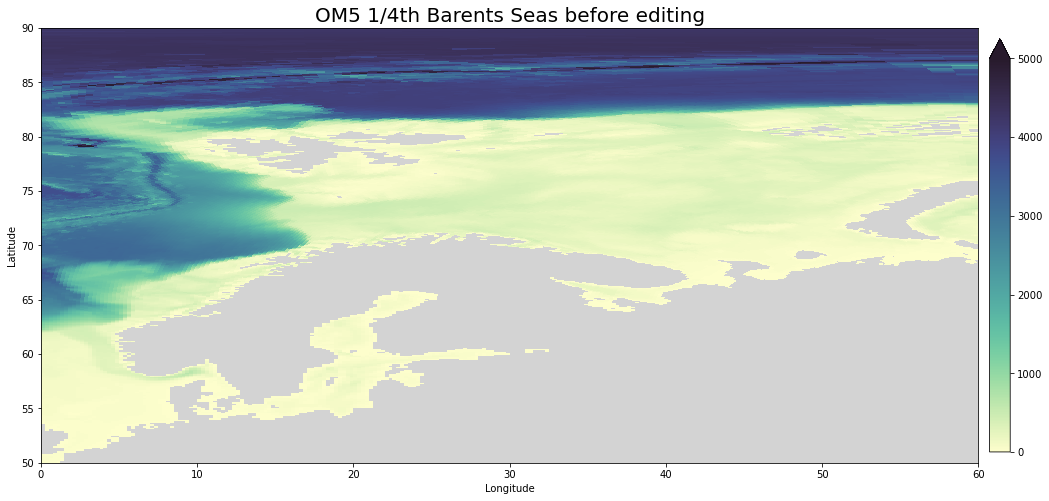

In [12]:
# Broad view before edits 

broadview((0,60), (50,90), 0, 5000, "Barents Seas", om4=False, new=False)

Gebco (js:je,is:ie) = 33839:34319,72959:73439
OM4 model (js:je,is:ie) = 740:755,1214:1224
OM5 model (js:je,is:ie) = 821:836,1214:1224
Using xlim = (4.0, 6.0) ylim = (51.0, 53.0)


/vftmp/Mitchell.Bushuk/pid155679/ipykernel_142754/1678323038.py:10: UserWarning: No contour levels were found within the data range.
  thisax.contour(GEBCO.lonh[Gis:Gie], GEBCO.lath[Gjs:Gje], zmask( GEBCO.depth[Gjs:Gje,Gis:Gie] ),


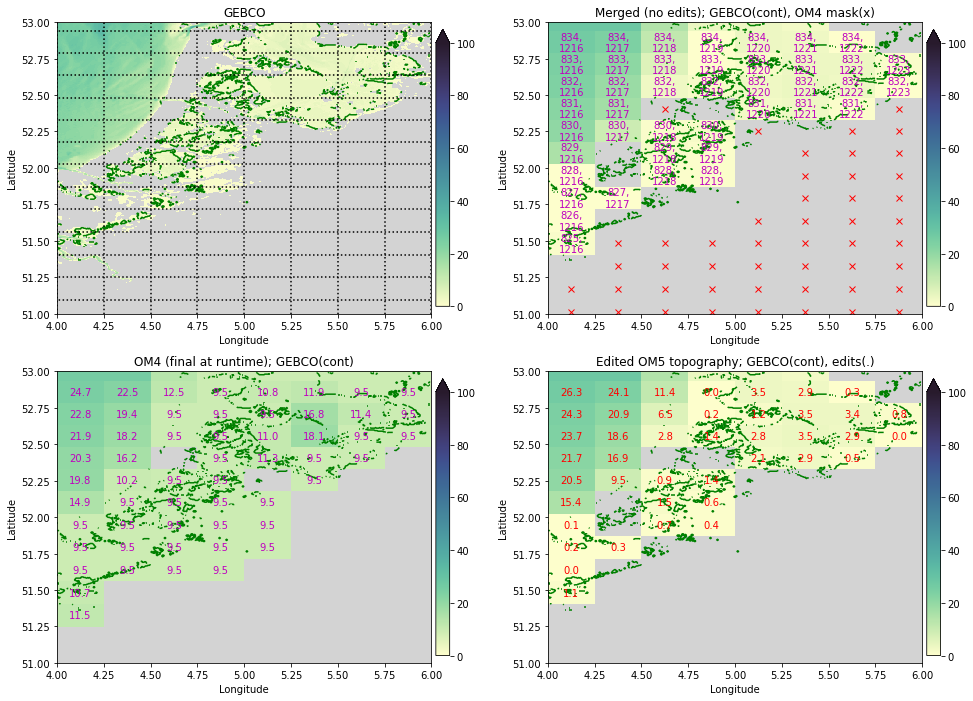

In [13]:
region = Region(5, 52, width_lon=2, width_lat=2)
OM5.reset(region)

#Note: decided to leave Amsterdam "as is"

map_region(region, 0, 100, GEBCO, OM4, OM5, '', gebco_contours=[0] )#, sill_check=[(-6.2,35.8,-4.8,36.1)])

Gebco (js:je,is:ie) = 35399:35879,77399:77879
OM4 model (js:je,is:ie) = 785:802,1288:1298
OM5 model (js:je,is:ie) = 866:883,1288:1298
Using xlim = (22.5, 24.5) ylim = (57.5, 59.5)


/vftmp/Mitchell.Bushuk/pid155679/ipykernel_142754/1678323038.py:10: UserWarning: No contour levels were found within the data range.
  thisax.contour(GEBCO.lonh[Gis:Gie], GEBCO.lath[Gjs:Gje], zmask( GEBCO.depth[Gjs:Gje,Gis:Gie] ),


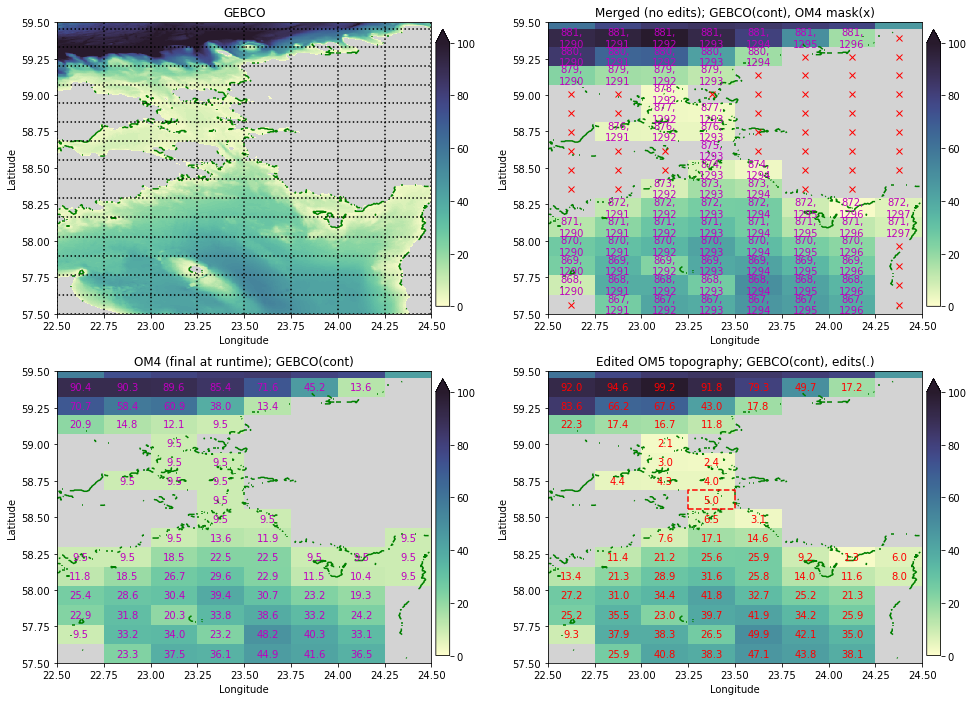

In [14]:
region = Region(23.5, 58.5, width_lon=2, width_lat=2)
OM5.reset(region)
OM5.depth[875,1293] = 5.0

map_region(region, 0, 100, GEBCO, OM4, OM5, '', gebco_contours=[0] )#, sill_check=[(-6.2,35.8,-4.8,36.1)])

In [15]:
OM5.write_nc("om5_topo_edits_region_24.nc")

AttributeError: 'OM5_data' object has no attribute 'write_nc'